## Importing Necessary Modules

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from typing import Any
from sklearn.model_selection import train_test_split

## Adding Paths

In [2]:
import os
from pathlib import Path

image_path = Path("../../data/")
print(os.listdir(image_path))

['1. Original Images', '2. All Segmentation Groundtruths', 'CC-BY-4.0.txt', 'LICENSE.txt']


In [3]:
X_train_dir = Path(image_path / "1. Original Images/a. Training Set")
y_train_dir = Path(image_path / "2. All Segmentation Groundtruths/a. Training Set/2. Haemorrhages")
X_val_dir = Path(image_path / "1. Original Images/b. Validation Set")
y_val_dir = Path(image_path / "2. All Segmentation Groundtruths/b. Validation Set/2. Haemorrhages")
X_test_dir = Path(image_path / "1. Original Images/c. Testing Set")
y_test_dir = Path(image_path / "2. All Segmentation Groundtruths/c. Testing Set/2. Haemorrhages")

print(os.listdir(X_train_dir)[:5])
print(os.listdir(y_train_dir)[:5])
print(os.listdir(X_val_dir)[:5])
print(os.listdir(y_val_dir)[:5])
print(os.listdir(X_test_dir)[:5])
print(os.listdir(y_test_dir)[:5])

['IDRiD_01.jpg', 'IDRiD_02.jpg', 'IDRiD_03.jpg', 'IDRiD_04.jpg', 'IDRiD_05.jpg']
['IDRiD_01_HE.tif', 'IDRiD_02_HE.tif', 'IDRiD_03_HE.tif', 'IDRiD_04_HE.tif', 'IDRiD_05_HE.tif']
['IDRiD_55.jpg', 'IDRiD_56.jpg', 'IDRiD_57.jpg', 'IDRiD_58.jpg', 'IDRiD_59.jpg']
['IDRiD_55_HE.tif', 'IDRiD_56_HE.tif', 'IDRiD_57_HE.tif', 'IDRiD_58_HE.tif', 'IDRiD_59_HE.tif']
['IDRiD_68.jpg', 'IDRiD_69.jpg', 'IDRiD_70.jpg', 'IDRiD_71.jpg', 'IDRiD_72.jpg']
['IDRiD_68_HE.tif', 'IDRiD_69_HE.tif', 'IDRiD_70_HE.tif', 'IDRiD_71_HE.tif', 'IDRiD_72_HE.tif']


### Training Image

255 0


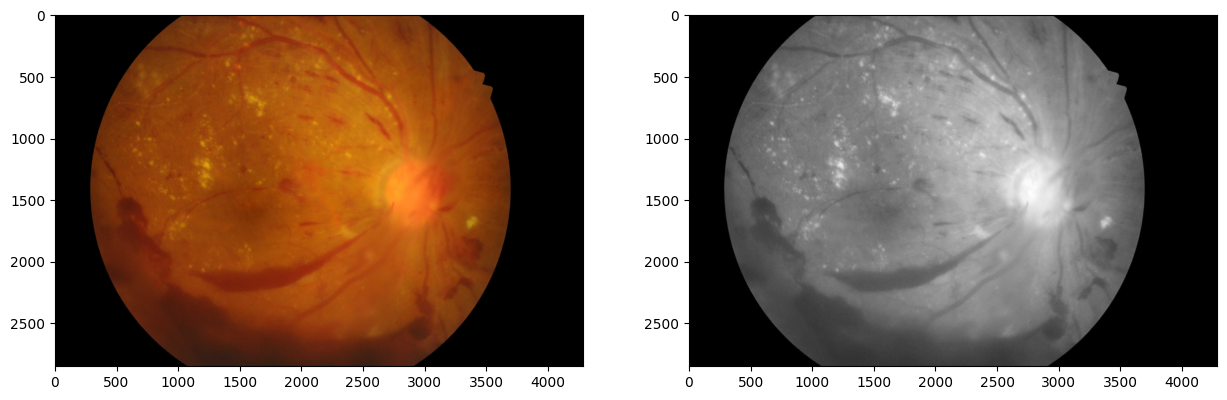

In [4]:
from PIL import Image, ImageOps

img = Image.open(Path(X_train_dir / os.listdir(X_train_dir)[16]))
img_grayed = ImageOps.grayscale(img)

numpy_img = np.asarray(img)
numpy_img_grayed = np.asarray(img_grayed)

plt.rcParams['figure.figsize'] = [15, 15]
fig, axis = plt.subplots(1, 2)
print(np.max(numpy_img), np.min(numpy_img))
axis[0].imshow(numpy_img)
axis[1].imshow(numpy_img_grayed, cmap="gray")

### Training Image Mask

1 0


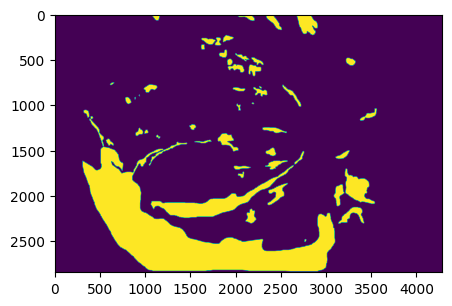

In [5]:
img_mask = Image.open(Path(y_train_dir  / "IDRiD_17_HE.tif"))

numpy_img = np.asarray(img_mask)

plt.rcParams['figure.figsize'] = [5, 5]
plt.imshow(numpy_img)
print(np.max(numpy_img), np.min(numpy_img))

## Preparing Data

In [6]:
img_height = 256
img_width = 256

In [7]:
def X_preprocess(image):
    image = tf.cast(image, tf.float32)
    image = tf.image.random_brightness(image, 0.2)
    #image = tf.image.random_hue(image, 0.1)
    image = tf.image.central_crop(image, 0.8)
    image = tf.image.resize_with_pad(image, img_height, img_width)
    image = (image / 255.0)
    return image

def y_preprocess(image):
    image = tf.image.central_crop(image, 0.8)
    image = tf.image.resize_with_pad(image, img_height, img_width)
    return image

# --------------------------------------------X train dataset--------------------------------------------------#
X_train = tf.keras.preprocessing.image_dataset_from_directory(
    X_train_dir,
    labels=None,
    batch_size=1,
    color_mode='grayscale',
    image_size=(img_height, img_width),
    shuffle=False,
    interpolation='bicubic',)
X_train = X_train.map(lambda x: (X_preprocess(x)))

# --------------------------------------------y train dataset--------------------------------------------------#
y_train_list = []
for images in os.listdir(y_train_dir):
    img = Image.open(Path(y_train_dir / images)).resize((img_width, img_height), resample=Image.NEAREST)
    img_arr = np.expand_dims(np.array(img, dtype="float32"), axis=-1)
    y_train_list.append(img_arr)
y_train_list = np.expand_dims(y_train_list, axis=1)
y_train = tf.data.Dataset.from_tensor_slices(y_train_list)
y_train = y_train.map(lambda x: (y_preprocess(x)))


# --------------------------------------------X val dataset----------------------------------------------------#
X_val = tf.keras.preprocessing.image_dataset_from_directory(
    X_val_dir,
    labels=None,
    batch_size=1,
    color_mode='grayscale',
    image_size=(img_height, img_width),
    shuffle=False,
    interpolation='bicubic',)
X_val = X_val.map(lambda x: (X_preprocess(x)))

# --------------------------------------------y val dataset----------------------------------------------------#
y_val_list = []
for images in os.listdir(y_test_dir):
    img = Image.open(Path(y_test_dir / images)).resize((img_width, img_height), resample=Image.NEAREST)
    img_arr = np.expand_dims(np.array(img, dtype="float32"), axis=-1)
    y_val_list.append(img_arr)
y_val_list = np.expand_dims(y_val_list, axis=1)
y_val = tf.data.Dataset.from_tensor_slices(y_val_list)
y_val = y_val.map(lambda x: (y_preprocess(x)))


# --------------------------------------------X test dataset---------------------------------------------------#
X_test = tf.keras.preprocessing.image_dataset_from_directory(
    X_test_dir,
    labels=None,
    batch_size=1,
    color_mode='grayscale',
    image_size=(img_height, img_width),
    shuffle=False,
    interpolation='bicubic')
X_test = X_test.map(lambda x: (X_preprocess(x)))

# --------------------------------------------y test dataset---------------------------------------------------#
y_test_list = []
for images in os.listdir(y_test_dir):
    img = Image.open(Path(y_test_dir / images)).resize((img_width, img_height), resample=Image.NEAREST)
    img_arr = np.expand_dims(np.array(img, dtype="float32"), axis=-1)
    y_test_list.append(img_arr)
y_test_list = np.expand_dims(y_test_list, axis=1)
y_test = tf.data.Dataset.from_tensor_slices(y_test_list)
y_test = y_test.map(lambda x: (y_preprocess(x)))


train_dataset = tf.data.Dataset.zip((X_train, y_train))
validation_dataset = tf.data.Dataset.zip((X_val, y_val))
test_dataset = tf.data.Dataset.zip((X_test, y_test))

Found 54 files belonging to 1 classes.
Found 13 files belonging to 1 classes.
Found 14 files belonging to 1 classes.


### Training Dataset

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(1, 256, 256, 1), dtype=tf.float32, name=None))>
(1, 256, 256, 1) (1, 256, 256, 1)
(256, 256, 1) (256, 256, 1)
0.78340364 0.0032368 1.0 0.0


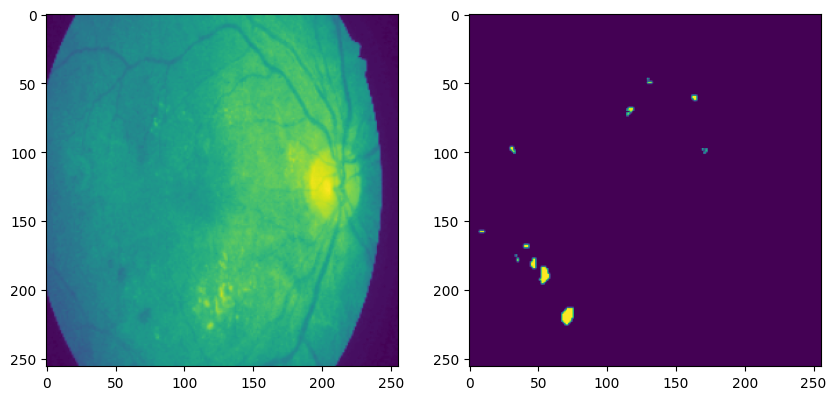

In [8]:
inp = train_dataset.take(1)
print(inp)
plt.rcParams['figure.figsize'] = [10, 10]
fig, axis = plt.subplots(1, 2)
for i, j in inp:
    print(i.shape, j.shape)
    print(i[0, :, :, :].shape, j[0, :, :, :].shape)
    print(np.max(i), np.min(i), np.max(j), np.min(j))
    axis[0].imshow(i[0, :, :, :])
    axis[1].imshow(j[0, :, : ,:])

### Validation Dataset

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(1, 256, 256, 1), dtype=tf.float32, name=None))>
(1, 256, 256, 1) (1, 256, 256, 1)
(256, 256, 1) (256, 256, 1)
0.7614369 -0.0003269317 1.0 0.0


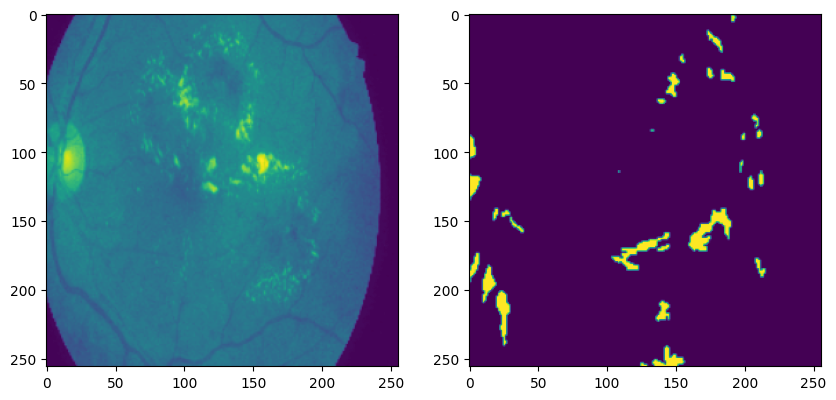

In [9]:
inp = validation_dataset.take(1)
print(inp)
plt.rcParams['figure.figsize'] = [10, 10]
fig, axis = plt.subplots(1, 2)
for i, j in inp:
    print(i.shape, j.shape)
    print(i[0, :, :, :].shape, j[0, :, :, :].shape)
    print(np.max(i), np.min(i), np.max(j), np.min(j))
    axis[0].imshow(i[0, :, :, :])
    axis[1].imshow(j[0, :, : ,:])

### Testing Dataset

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(1, 256, 256, 1), dtype=tf.float32, name=None))>
(1, 256, 256, 1) (1, 256, 256, 1)
(256, 256, 1) (256, 256, 1)
0.71228296 0.0010159746 1.0 0.0


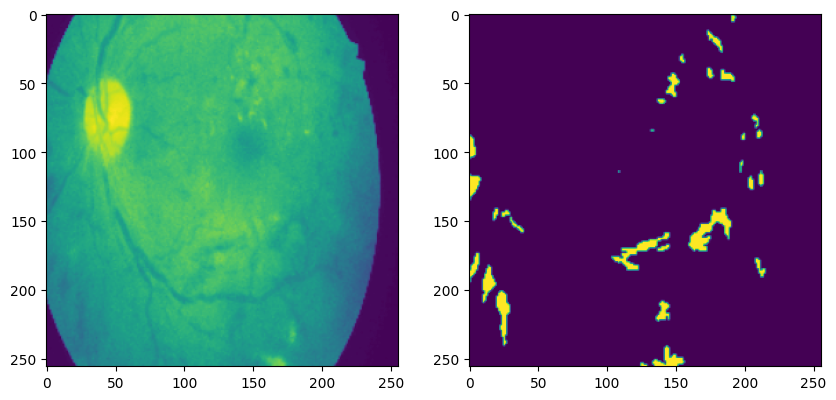

In [10]:
inp = test_dataset.take(1)
print(inp)
plt.rcParams['figure.figsize'] = [10, 10]
fig, axis = plt.subplots(1, 2)
for i, j in inp:
    print(i.shape, j.shape)
    print(i[0, :, :, :].shape, j[0, :, :, :].shape)
    print(np.max(i), np.min(i), np.max(j), np.min(j))
    axis[0].imshow(i[0, :, :, :])
    axis[1].imshow(j[0, :, : ,:])

## U-Net Model

In [11]:
from keras.models import Model
from keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, Input, Concatenate, Dropout, BatchNormalization, Activation, Dense


def conv_block(inp, filters):
    conv = Conv2D(filters, 3, padding='same')(inp)
    conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    
    conv = Conv2D(filters, 3, padding='same')(conv)
    conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    return conv


def encoder_layer(inp: Any, filters:int):
    enc = conv_block(inp, filters)
    enc_pool = MaxPool2D((2, 2))(enc)
    return enc, enc_pool


def decoder_layer(inp:Any, skip_connections:Any, filters:int) -> Any:
    dec = Conv2DTranspose(filters, (2, 2), strides=2, padding='same')(inp)
    dec = Concatenate()([dec, skip_connections])
    dec = conv_block(dec, filters)
    return dec

In [12]:
def UNet(input_shape):
    inputs = Input(input_shape)
    print("Inputs:", inputs)

    ds1, dp1 = encoder_layer(inputs, 64)        # downsampling layer1 → → → → → → → → →
                                                #   ↓                                 ↓
    ds2, dp2 = encoder_layer(dp1, 128)          # downsampling layer2 → → → → → → →   ↓  
                                                #   ↓                             ↓   ↓
    ds3, dp3 = encoder_layer(dp2, 256)          # downsampling layer3 → → → → →   ↓   ↓ 
                                                #   ↓                         ↓   ↓   ↓
    ds4, dp4 = encoder_layer(dp3, 512)          # downsampling layer4 → → →   ↓   ↓   ↓
                                                #   ↓                     ↓   ↓   ↓   ↓
    bc = Dropout(0.1)(conv_block(dp4, 1024))    # bridge connect layer    ↓   ↓   ↓   ↓
                                                #   ↓                     ↓   ↓   ↓   ↓
    us1 = decoder_layer(bc, ds4, 512)           # upsampling layer1 ← ← ← ←   ↓   ↓   ↓
                                                #   ↓                         ↓   ↓   ↓
    us2 = decoder_layer(us1, ds3, 256)          # upsampling layer2 ← ← ← ← ← ←   ↓   ↓
                                                #   ↓                             ↓   ↓
    us3 = decoder_layer(us2, ds2, 128)          # upsampling layer3 ← ← ← ← ← ← ← ←   ↓    
                                                #   ↓                                 ↓
    us4 = decoder_layer(us3, ds1, 64)           # upsampling layer4 ← ← ← ← ← ← ← ← ← ←


    output = Conv2D(1, 1, padding="same", activation="sigmoid")(us4)

    model = Model(inputs, output, name="UNet")

    return model

In [13]:
from helpers.helper import TfMetrics, NpMetrics
from keras.optimizers import Adam, RMSprop

metrics = TfMetrics()
model = UNet([img_height, img_width, 1])
model.compile(optimizer=Adam(), 
            loss=metrics.iou_loss,
            metrics=[metrics.iou])
model.summary()

Using TensorFlow backend


Inputs: KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  

In [14]:
#tf.keras.utils.plot_model(model, show_shapes=True)

## Training Model

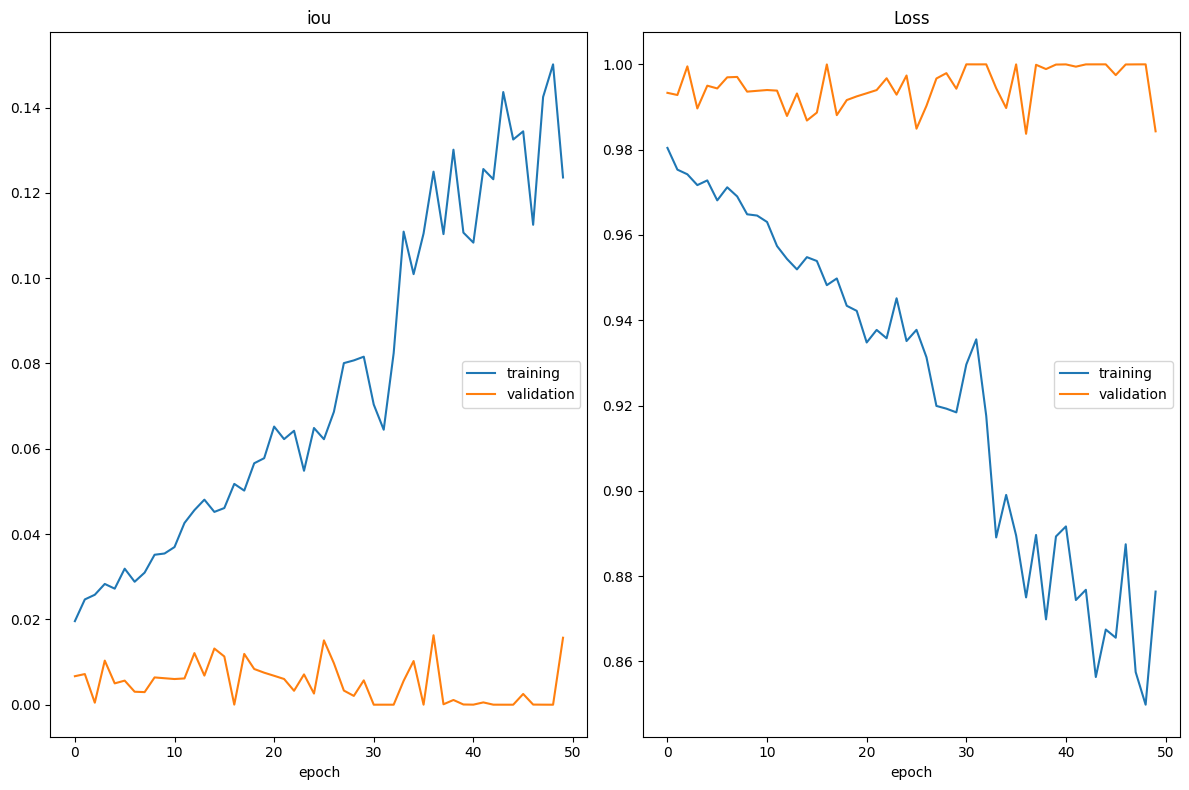

iou
	training         	 (min:    0.020, max:    0.150, cur:    0.124)
	validation       	 (min:    0.000, max:    0.016, cur:    0.016)
Loss
	training         	 (min:    0.850, max:    0.980, cur:    0.876)
	validation       	 (min:    0.984, max:    1.000, cur:    0.984)
53/53 - 11s - loss: 0.8764 - iou: 0.1236 - val_loss: 0.9843 - val_iou: 0.0157 - 11s/epoch - 207ms/step


In [15]:
from livelossplot import PlotLossesKeras

batch_size = 8
model.fit(train_dataset, validation_data=validation_dataset, callbacks=[PlotLossesKeras()], batch_size=batch_size, epochs=50, verbose=2)

In [16]:
#model.save("model.h5")

## Predictions

14/14 [==============================] - 1s 62ms/step
(14, 256, 256, 1)


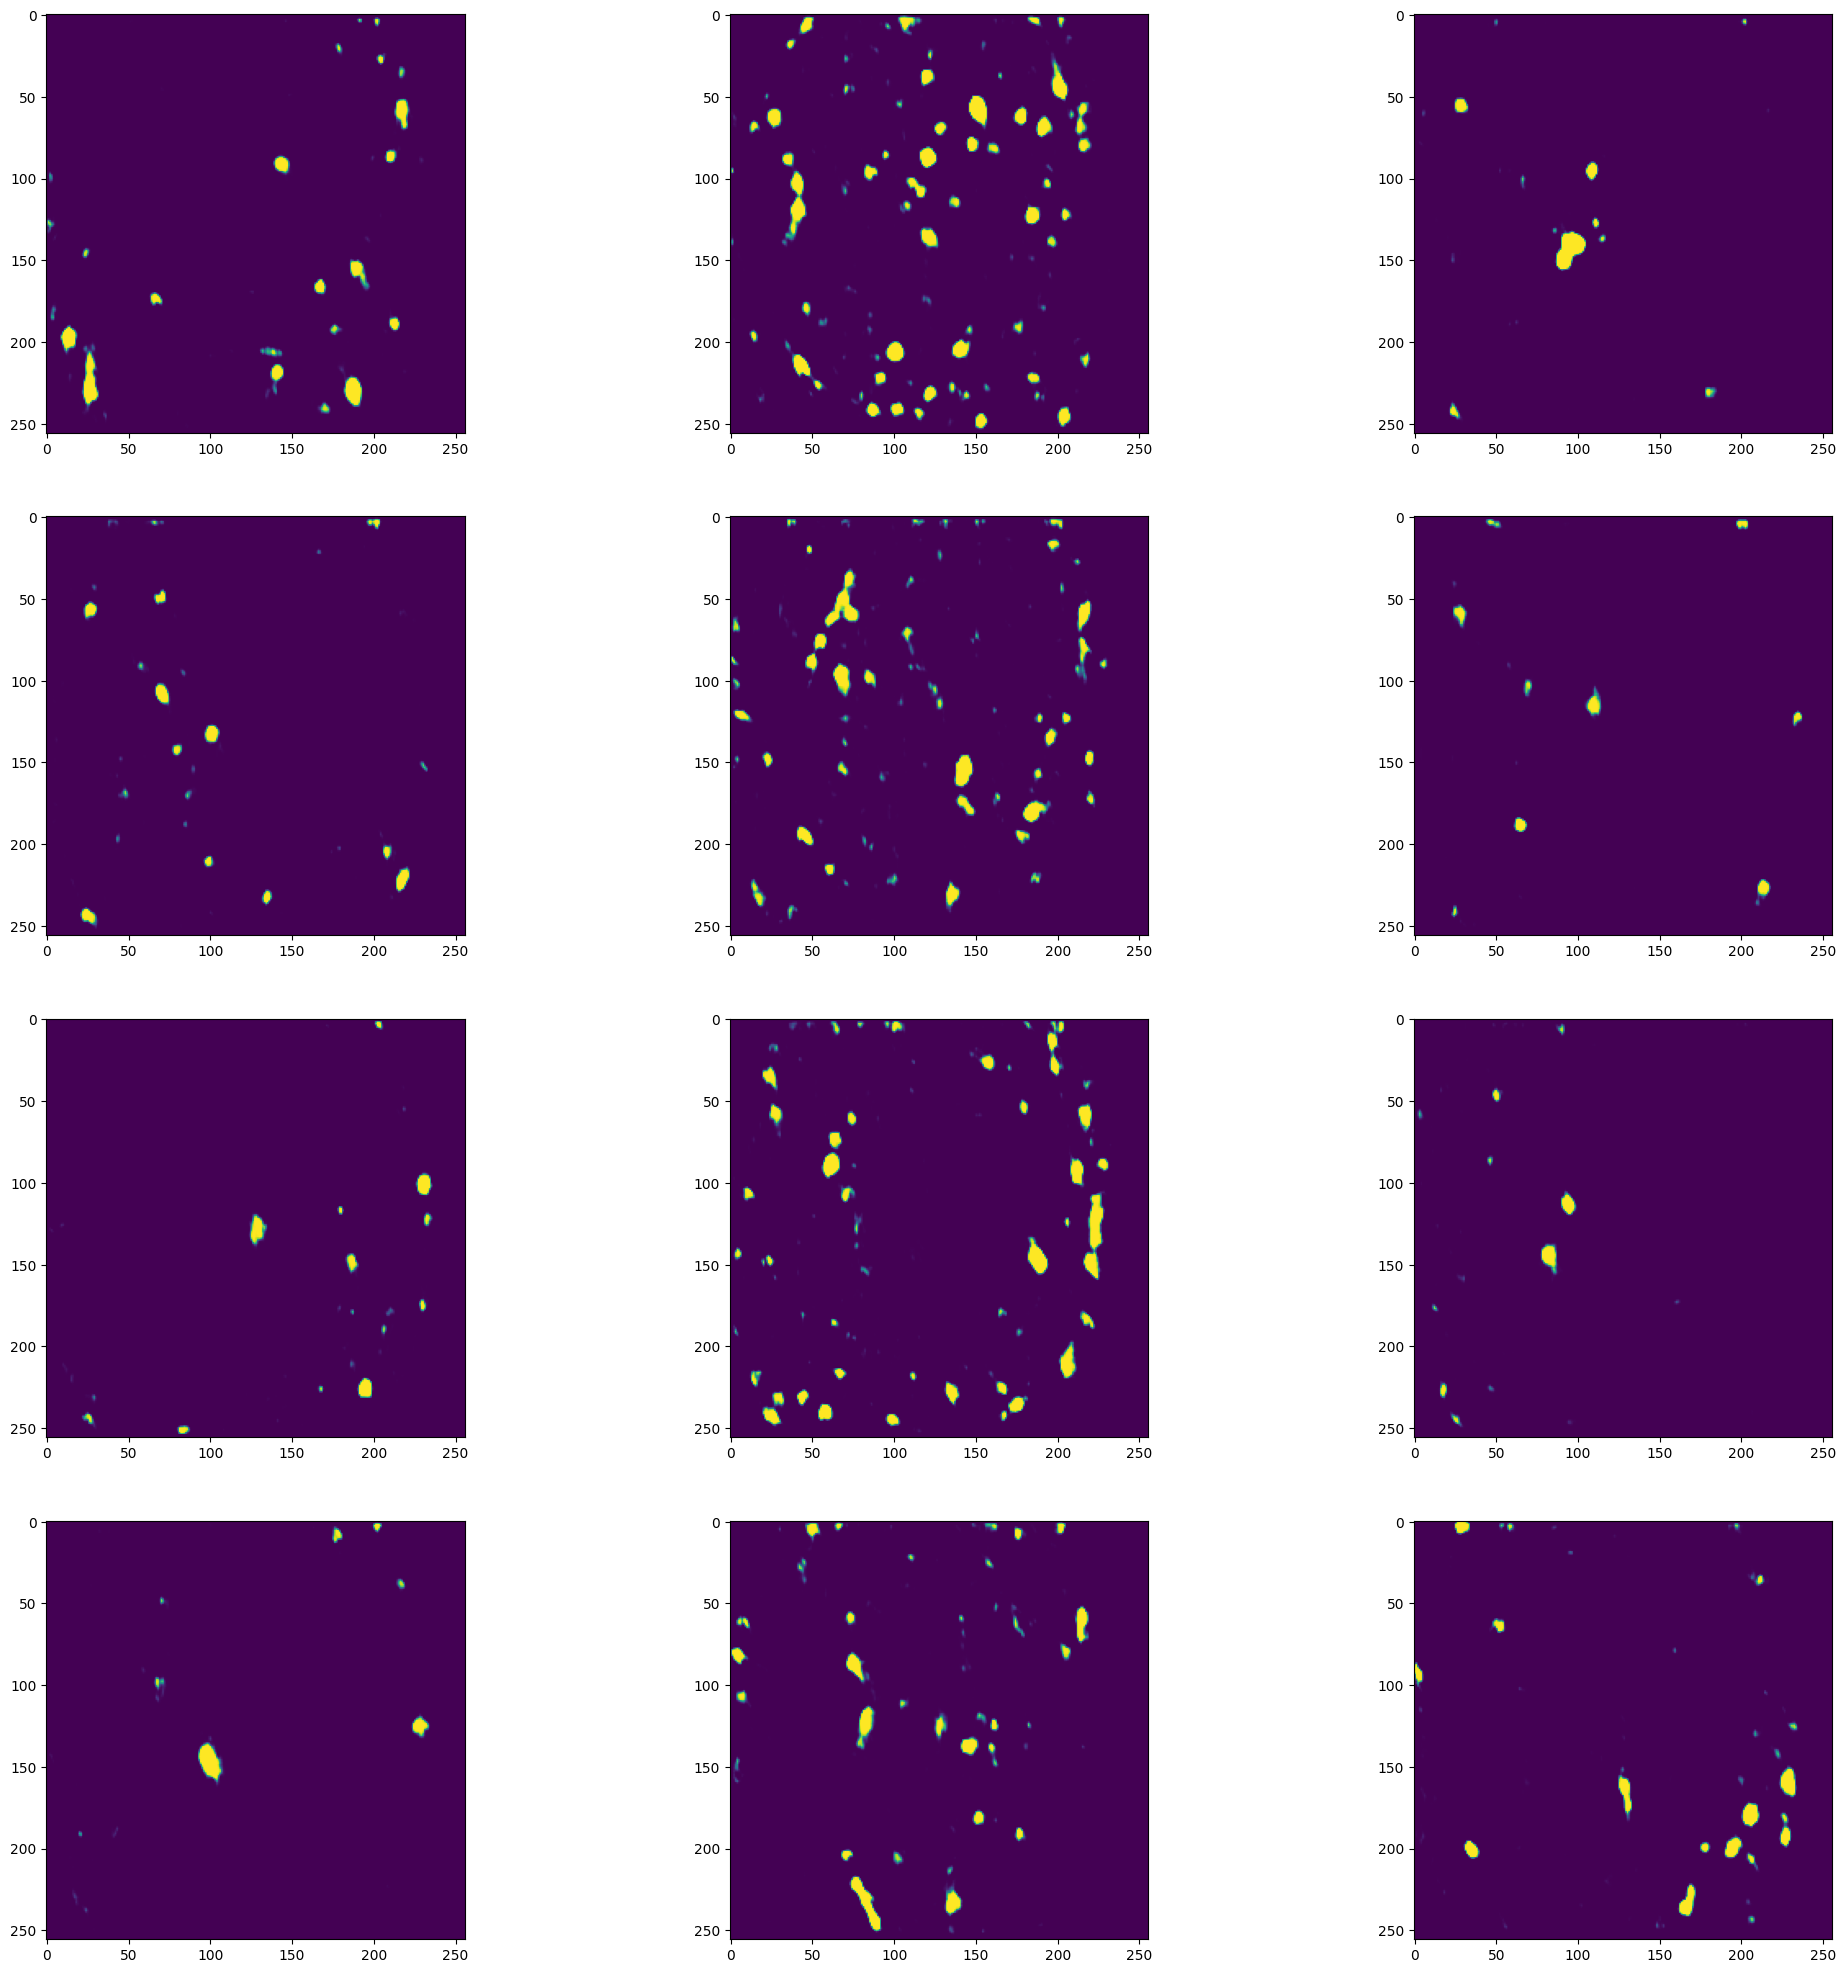

In [17]:
img = model.predict(test_dataset)
rows, cols = 4, 3
print(img.shape)

plt.rcParams['figure.figsize'] = [25, 25]
fig, axis = plt.subplots(rows, cols)
c = 0
for i in range(rows):
    for j in range(cols):
        axis[i][j].imshow(img[c])
        c += 1        

In [18]:
img_no = 11

In [19]:
truth = test_dataset.take(img_no + 1)
x_truth_vals, y_truth_vals = [], []
for vals in truth:
    x_true, y_true = vals
    x_truth_vals.append(x_true)
    y_truth_vals.append(y_true)

Text(0.5, 1.0, 'Predicted Mask')

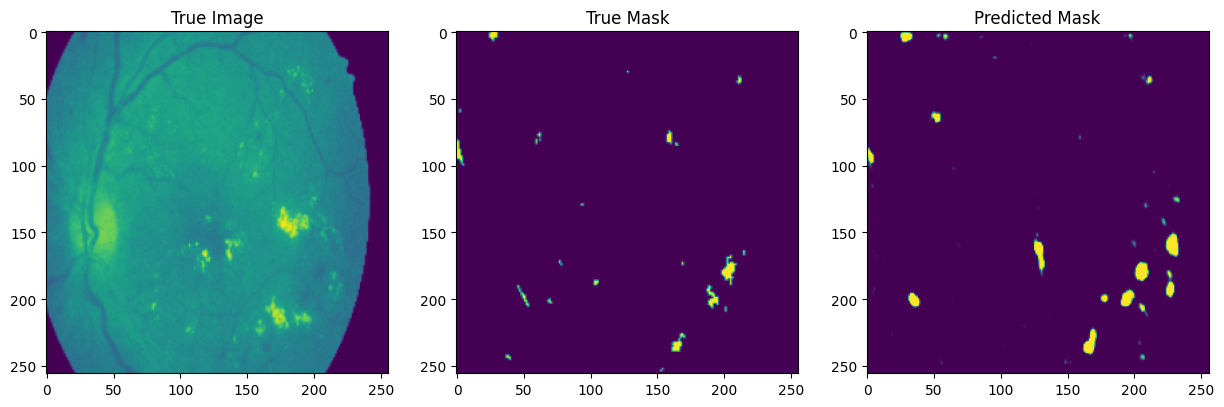

In [20]:
plt.rcParams['figure.figsize'] = [15, 15]
fig, axis = plt.subplots(1, 3)

# True Image
axis[0].imshow(x_truth_vals[img_no][0, :, :, :])
axis[0].set_title("True Image")

# True Mask
axis[1].imshow(y_truth_vals[img_no][0, :, :, :])
axis[1].set_title("True Mask")

# Predicted Mask
y_pred = img[img_no]
axis[2].imshow(y_pred)
axis[2].set_title("Predicted Mask")

In [21]:
npmetrics = NpMetrics(y_truth_vals[img_no][0, :, :, :].numpy(), img[img_no])
print("IOU Accuracy:", npmetrics.iou())

IOU Accuracy: 0.20976122


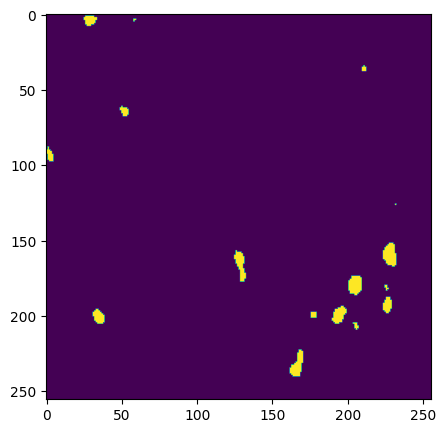

In [22]:
plt.rcParams['figure.figsize'] = [5, 5]
maximum = np.max(img[img_no])
minimum = np.min(img[img_no])
mask = (img[img_no] > 0.9).astype(float)
plt.imshow(mask)